# Исследовательский анализ аренды самокатов

Нужно проанализировать данные популярного сервиса аренды самокатов GoFast. Они содержат информацию о некоторых пользователях из нескольких городов, а также об их поездках. После анализа данных необходимо проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

**Без подписки**
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей.

**С подпиской Ultra**
-  абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

В рамках исследования мы:
1. Познакомимся с данными для работы. 
2. Обработаем их на предмет пропусков и дубликатов. 
3. Опишем и визуализируем общую информацию о пользователях и поездках.
4. Проведём необходимые агрегации и дополнительные подсчёты, которые помогут нам проверить гипотезы. 
5. Проверим гипотезы заказчика и сделаем по ним выводы. 

**Оглавление:**
1. [Изучение данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных](#3)
4. [Объединение данных](#4)
5. [Подсчёт выручки](#5)
6. [Проверка гипотез](#6)
7. [Общий вывод](#7)

<a id="1"></a>
## Изучение данных

Подгружаем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import binom
from math import sqrt

**1.1** Сохраним 3 датафрейма с необходимыми для работы данными в 3 переменные:

`users` - данные о пользователях, их поездках и подписках.

`rides` - данные о поездках.

`subscription` - данные о подписках.


In [2]:
users = pd.read_csv('datasets/users_go.csv')
rides = pd.read_csv('datasets/rides_go.csv')
subscription = pd.read_csv('datasets/subscriptions_go.csv')

**1.2** Выведем первые строки каждого набора данных и изучим общую информацию о каждом датафрейме.

In [3]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


**1.3** Датафрейм `users` состоит из 1 565 строк и 5 столбцов:

`user_id` - уникальный идентификатор пользователя.

`name` - имя пользователя.

`age` - возраст пользователя.

`city` - город.

`subscription_type` - тип подписки (free, ultra).

В данных нет пропусков, а типы данных каждого из столбов соответствуют содержанию.

In [5]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


**1.4** Датафрейм `rides` состоит из 18 068 строк и 4 столбцов.

`user_id` - уникальный идентификатор пользователя.

`distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах).

`duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку».

`date` - дата совершения поездки.

В таблице нет пропусков, а типы данных в каждом из столбцов соответствуют содержанию, кроме столбца `date`: для того, чтобы можно было проводить с ним операции, надо будет перевести данные в тип `datetime`. 

In [7]:
subscription.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


**1.5** Датафрейм состоит из 2 строк и 4 столбцов.

`subscription_type` - тип подписки.

`minute_price` - стоимость одной минуты поездки по данной подписке.

`start_ride_price` - стоимость начала поездки.

`subscription_fee` - стоимость ежемесячного платежа.

В данных нет пропусков, а типы данных каждого из столбов соответствуют содержанию.

<a id="2"></a>
##  Предобработка данных

**2.1** Как мы выяснили, все столбцы в датафреймах имеют корректный тип данных, кроме столбца `date` в таблице `rides`. Переведем данный столбец в тип `datetime`. 

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


**2.2** Создадим новый столбец с номером месяца на основе столбца `date`.

In [10]:
rides['month'] = rides['date'].dt.month

**2.3** Дополнительно выведем минимальное и максимальное значение в столбце `date`, чтобы проверить, данные за какой период имеются в нашем распоряжении.

In [11]:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [12]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

**2.4** Таким образом мы узнали, что работаем с данными за один год (2021).

Проверим наличие пропущенных значений и дубликатов в датафреймах.

Из метода `info` было видно, что пропущенных значений в таблице нет. На всякий случай убедимся в этом на 100% про помощи метода `isna()`.

In [13]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [14]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [15]:
subscription.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**2.5** Теперь проверим наличие дубликатов в таблицах `users` и `rides` (датафрейм с подписками состоит из 2 строк, из-за чего визуально видно, что дубликатов там нет).

Начнём с таблицы `users`.

In [16]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


**2.6** Сначала проверим датафрейм на наличие явных дубликатов. И удалим таковые, если они имеются. 

In [18]:
print(users.duplicated().sum())

31


In [20]:
users = users.drop_duplicates().reset_index(drop=True)

**2.7** Теперь проверим, нет ли повторяющихся id после удаления явных дубликатов. Для этого проверим, сколько строк осталось в таблице `users`, а затем посчитаем количество уникальных значений в столбце `user_id`. Если значения равны, значит, повторяющихся id не осталось.

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.1+ KB


In [22]:
users['user_id'].nunique()

1534

**2.8** В таблице остались только униикальные id пользователей. 

Теперь проверим значения в столбце `city`, чтобы исключить возможность неявных дубликатов.

In [23]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

**2.9** Все значения в столбце `city` униикальны. Таком образом, датафрейм `users` очищен от дубликатов (имена, возраст и тип подписки могут быть одинаковыми у разных пользователей). 

**2.10** Теперь проверим датафрейм `rides`.

In [24]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**2.11** В этой таблице могут повторяться значения в любых из столбцов, и это не будет считаться дубликатом. Например, 2 разных пользователя могут проехать одинаковое расстояние или затратить на поездку одиноковое время. Поэтому проверим датафрейм только на явные дубликаты и удалим их, если таковые имеются.

In [26]:
print(rides.duplicated().sum())

0


**2.11** Дубликатов нет. 

**Вывод по предобработке:**

**Таблица `users`**:
- Был удалён 31 явный дубликат.

**Таблица `rides`**:
- Тип данных столбца `date` был переведен из `object` в `datetime`.

**Таблица `subscription`**:
- Изменений не было.

Пропусков и неявных дубликатов в тиблицах не обнаружено. 

<a id="3"></a>
##  Исследовательский анализ данных

**3.1** Опишем и визуализируем общую информацию о пользователях и их поездках.

Сначала определим **частоту встречаемости городов**. Для этого сгруппируем данные `users` по столбцу `city` по убыванию и построим столбчатую диаграмму. 


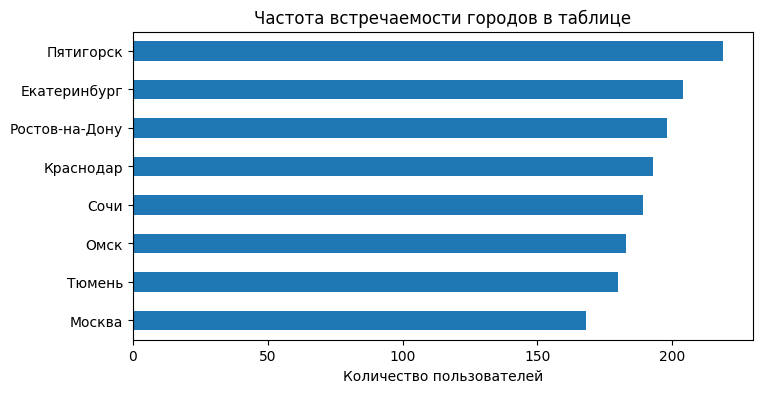

In [30]:
users.value_counts('city', ascending=True).plot(kind='barh', figsize=(8,4))
plt.title('Частота встречаемости городов в таблице')
plt.xlabel('Количество пользователей')
plt.ylabel(None)
plt.show()

In [31]:
users.value_counts('city', ascending=False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

**3.2** Можно сказать, что количество пользователей в городах **распределено достаточно равномерно**. От 168 до 219 пользователей. 
Стоит отметить, что в данных больше всего пользователей из Пятигорска (219), а меньше всего из Москвы (168).
Остальные города имеют небольшой разброс относиельно друг друга: от 180 до 204 пользователей. 

Теперь проверим **соотношение пользователей с подпиской и без подписки**.

Для этого выведем количество пользователей с подпиской и без на столбчатой диаграмме, а также определим количество пользователей с подпиской по отношению к пользователям без подписки.

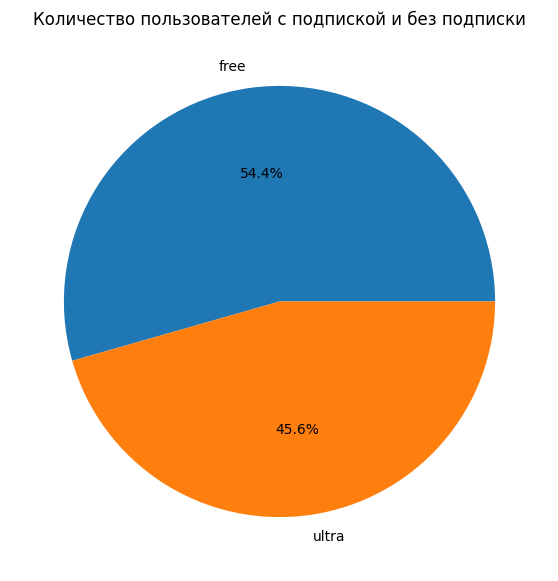

In [33]:
users.groupby('subscription_type')['subscription_type'].count().plot(kind='pie', figsize=(7,7), autopct='%1.1f%%')
plt.title('Количество пользователей с подпиской и без подписки')
plt.ylabel(None)
plt.show()

In [35]:
print(users.query('subscription_type == "ultra"')['subscription_type'].count() / \
users.query('subscription_type == "free"')['subscription_type'].count())

0.837125748502994


**3.3** Как видно из графика, пользователей с платной подпиской достаточно много (их количество близится к числу пользователей без подписки). Соотношение клиентов с подпиской и без — 0.84 к 1 соответственно. 

Можно сказать, что среди пользователей самокатов достаточно большой процен имеет платную подписку. 

Теперь визуализируем **возраст пользователей**.

In [36]:
users.groupby('age')['age'].count()

age
12      4
13      8
14      9
15     13
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
36      6
37      2
38      3
39      1
43      1
Name: age, dtype: int64

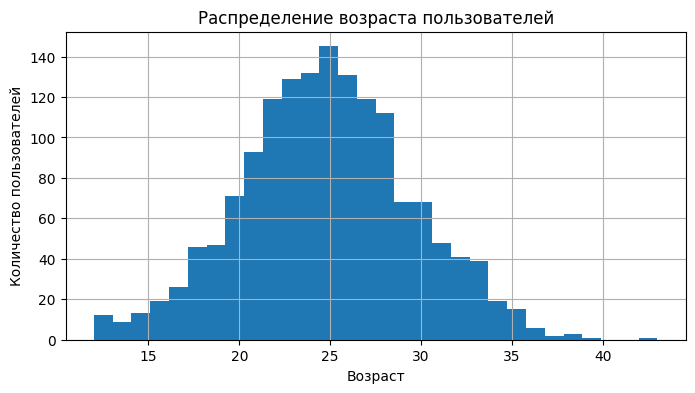

In [37]:
users['age'].hist(bins = 30, figsize = (8,4))
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

In [38]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

**3.4** Возраст пользователей распредлён в таблиице нормально (колоколообразно). Средний возраст составляет 25 лет (145 клиентов). Средует отметить, что более 75% имеют возраст до 30 лет. Сделовательно, можно сделать вывод, что пользователи самокатов являются молодой аудиторией. Всего 13 человек из всех клиенов находятся в возрасте от 35 лет до 43 лет. Самые молодые пользователи — 12-летние.

Теперь проверим, как распределено **расстояние, которое пользователи преодолевают за одну поездку**.

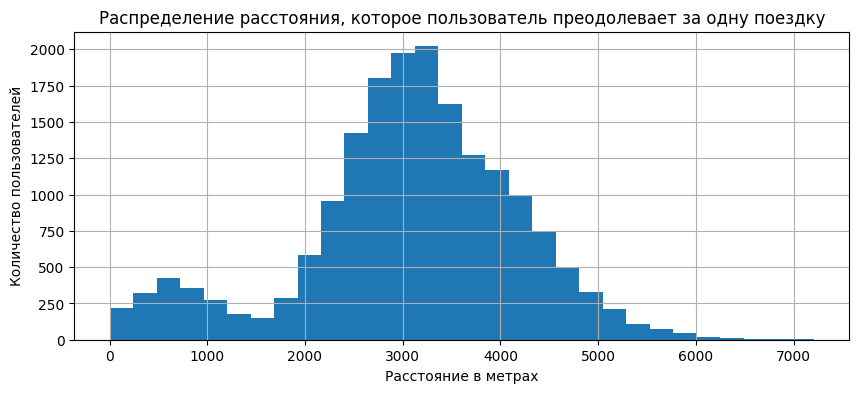

In [39]:
rides['distance'].hist(bins=30, figsize=(10,4))
plt.title('Распределение расстояния, которое пользователь преодолевает за одну поездку')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
plt.show()

In [40]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

**3.5** На гистограмме видно, что самая популярная дистанция, которую проезжает пользователь за одну поездку, — примерно 3-3,3 км. И подавляющее большинство поездок распределены в интервале от 2 до 4,5 км. 
Стоит отметить, что пройденное расстояние около 220-230 поездок близко к нулю. Возможно, клиенты не разобрались в управлении или передумали пользоваться самокатом, так как вряд ли пользователь будет брать самокат, чтобы преодолеть расстояние в 50 метров. Стоит обратить внимание на эти данные. 

Теперь рассмотрим **продолжительность поездок**.

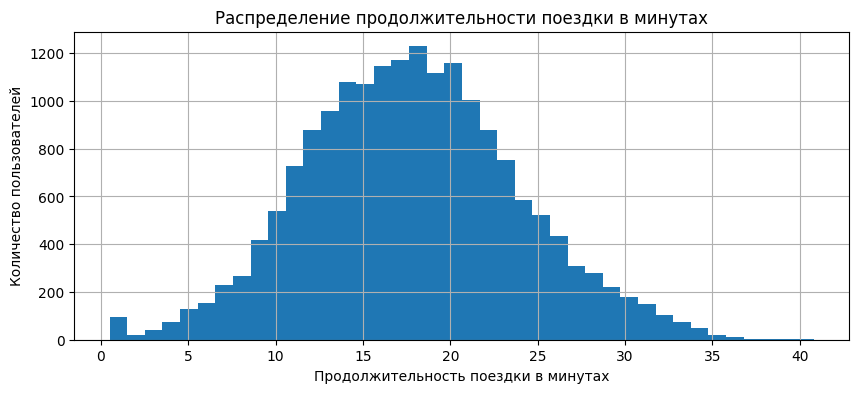

In [41]:
rides['duration'].hist(bins=40, figsize=(10,4))
plt.title('Распределение продолжительности поездки в минутах')
plt.xlabel('Продолжительность поездки в минутах')
plt.ylabel('Количество пользователей')
plt.show()

In [42]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

**3.6** Самое популярное время поездки — 17 минут. Это показывает как среднее, так и медиана. Более 75% поездок длятся не более 22 минут. В большинстве своём поездка длится от 9 до 26 минут. 
Стоит отметить, что как и с дистанцией, здесь прослеживаются очень непродолжительные поездки, близкие по времени к нулю.

**3.7** Посмотрим детальнее на столбцы с продолжительностью поездки и её расстоянием, где значения близки к нулю. 

Для столбца `duration` возьмём значения меньше 3 минут, а для столбца `distance` возьмем значения менее 100 метров.

In [43]:
rides.query('duration < 3').head(15)

,user_id,distance,duration,date,month
6531,701,4196.445201,0.500000,2021-08-31,8
6570,704,4830.824371,0.500000,2021-10-14,10
6680,712,4684.004397,0.500000,2021-03-04,3
6691,712,23.963062,2.053251,2021-11-22,11
6695,713,5215.642710,0.500000,2021-02-25,2
6768,718,5197.436649,0.500000,2021-02-11,2
6801,720,102.323624,2.292353,2021-09-20,9
6860,724,6225.520342,0.500000,2021-12-16,12
6883,726,4452.491518,0.500000,2021-03-01,3
7018,735,4406.954812,0.500000,2021-04-13,4


In [44]:
rides.query('distance < 100').head(15)

,user_id,distance,duration,date,month
6611,707,28.793204,14.143966,2021-09-12,9
6691,712,23.963062,2.053251,2021-11-22,11
6816,721,62.568138,7.178766,2021-09-25,9
6850,724,30.473763,3.166221,2021-05-09,5
7367,760,54.724068,8.164172,2021-10-13,10
7389,762,35.061903,7.087655,2021-05-27,5
7595,779,83.977452,3.419887,2021-09-10,9
7841,796,7.097072,10.026614,2021-11-26,11
8324,835,12.233115,4.034952,2021-09-19,9
8658,861,6.784447,6.015656,2021-07-21,7


**3.8** Из срезов данных стало понятно, что, скорее всего, значения в `duration`, близкие к нулю, появились из-за сбоя подсчёта времени. Так как мы видим, что у многих больших расстояний указана продолжительность поездки в 0.5 минуты. Скорее всего, алгоритм записал везде эту продолжительность поездки, где не смог считать реальные значения продолжительности. Я бы посоветовала удалить из таблицы строки, где продожительность поездки равна 0.5.

Со столбцом `distance` не всё так однозначно. Есть клиенты, которые проехали меньше 100 метров за 10 и более минут. Возможно, они забыли завершить поездку, передумав кататься, или были какие-то другие причины. Но на систематический сбой в данных это не похоже. Можно тоже удалить такие поездки из данных, так как вряд ли они отражают поведение среднестатистического клиента. 

**Вывод:**

- Количество пользователей в городах распределено достаточно равномерно: от 168 до 219 пользователей. Больше всего пользователей из Пятигорска (219), а меньше всего из Москвы (168). Остальные города имеют небольшой разброс относиельно друг друга: от 180 до 204 пользователей.
- Среди пользователей самокатов достаточно большой процент имеет платную подписку. Соотношение клиентов с подпиской и без — 0.84 к 1 соответственно.
- Пользователи самокатов являются молодой аудиторией. Средний возраст составляет 25 лет. Средует отметить, что более 75% имеют возраст до 30 лет. Самые молодые пользователи — 12-летние.
- Самая популярная дистанция, которую проезжает пользователь за одну поездку, — примерно 3-3,3 км. Подавляющее большинство поездок распределены в интервале от 2 до 4,5 км. Стоит отметить, что расстояние около 220-230 поездок близко к нулю. Возможно, стоит обратитть внимание на эти данные.
- Самое популярное время поездки — 17 минут. Более 75% поездок длятся не более 22 минут. В продолжительности поездки также прослеживаются экстремально низкие значения.

<a id="4"></a>
##  Объединение данных

**4.1** Объединим данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуемся методом `merge()`. Предварительно выведем на экран все таблицы, чтобы было проще работать.

In [45]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [46]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [47]:
subscription.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [48]:
users_and_rides = users.merge(rides, on='user_id')
full_info = users_and_rides.merge(subscription, on='subscription_type')

In [49]:
full_info.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


**4.2** Проверим количество строк полученной таблицы и сравним это значение с количеством строк таблиц до объединения. В данном случае мы знаем, что больше всего строк было у датафрейма `rides`. Именно на количество строк этой таблицы и будем ориентироваться, так как данные остальных таблиц должны были сагрегироваться с `rides`.

In [50]:
len(full_info)

18068

In [51]:
len(rides)

18068

**4.3** Количество строк одинаковое, значит, агрегация прошла верно. 

Мы объединили данные из 3 таблиц и записали их в переменную `full_info`.

Теперь на основе полной таблицы создадим два датафрейма: с пользователями без подписки и с пользователями, имеющими подписку (`users_ultra` и `users_free`).

In [52]:
users_ultra = full_info.query('subscription_type == "ultra"')

In [53]:
users_free = full_info.query('subscription_type == "free"')

**4.4** Проверим, правильно ли распределились данные. 

In [54]:
full_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


In [55]:
users_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int32         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 634.8+ KB


In [56]:
users_ultra['subscription_type'].unique()

array(['ultra'], dtype=object)

In [57]:
users_free.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int32         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.1+ MB


In [58]:
users_free['subscription_type'].unique()

array(['free'], dtype=object)

**4.5** Все колонки сохранены и сумма строк `users_ultra` и `users_free` равна количеству строк `full_info`. Колонки тоже сохранены. В таблице `users_ultra` только пользователи с подпиской, а в `users_free` — без подписки. Всё распределено правильно. 



**4.6** Теперь визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

Начнём с **данных о преодолеваемом расстоянии пользователями с подпиской и без неё**.

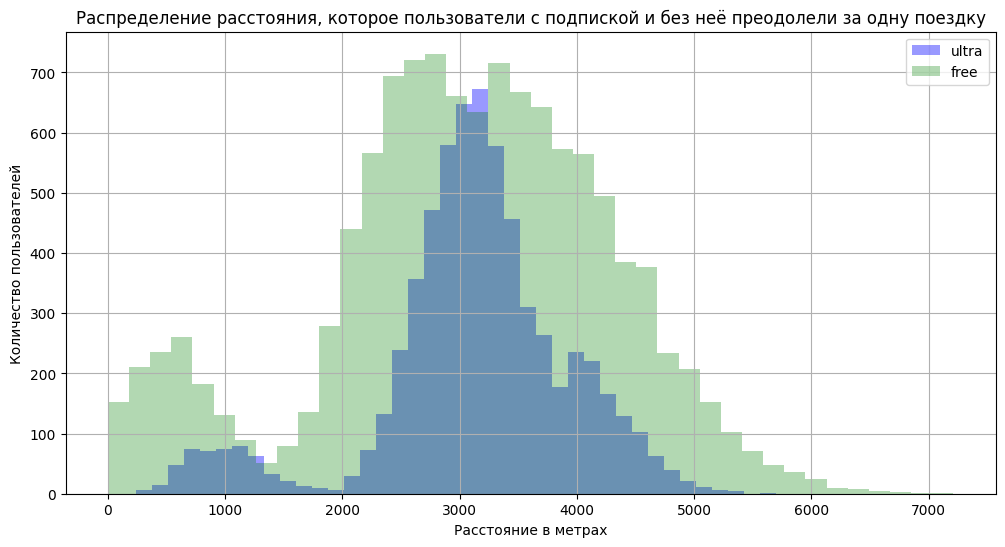

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(users_ultra['distance'], bins=40, alpha=0.4, label='ultra', color='blue')
ax.hist(users_free['distance'], bins=40, alpha=0.3, label='free', color='green')
plt.title('Распределение расстояния, которое пользователи с подпиской и без неё преодолели за одну поездку')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid()

In [60]:
users_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [61]:
users_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

**4.7** По данным видно, что самое популярное расстояние, которые преодолевают пользователи с подпиской, составляет около 3 км. А то время как у пользователей без подписки пик значений лежит в большем диапазоне (от 2,4 до 3,4 км). Стоит отметить, что среднее и медианное значение у обоих типов пользователей почти одинаковы. 

При этом пользователи без подписки иногда преодолевают расстояния сверх 5,5 км, чего нельзя сказать о платных пользователях. 


В целом у пользователей без подписки разброс расстояния шире. Это может свидетельствовать о том, что такие клиенты совершают нерегулярные поездки, в то время как пользователи с подпиской часто ездят по одному маршруту (например, на работу).


Также стоить отметить, что у пользователей без подписок больше поездок до 1 км. Опять же, возможно, наличие платной подписки свидетельствует о том, что клиенты ориентированы на более длинные расстояния.

Теперь посмотрим **данные о времени поездки пользователей с подпиской и без неё**.

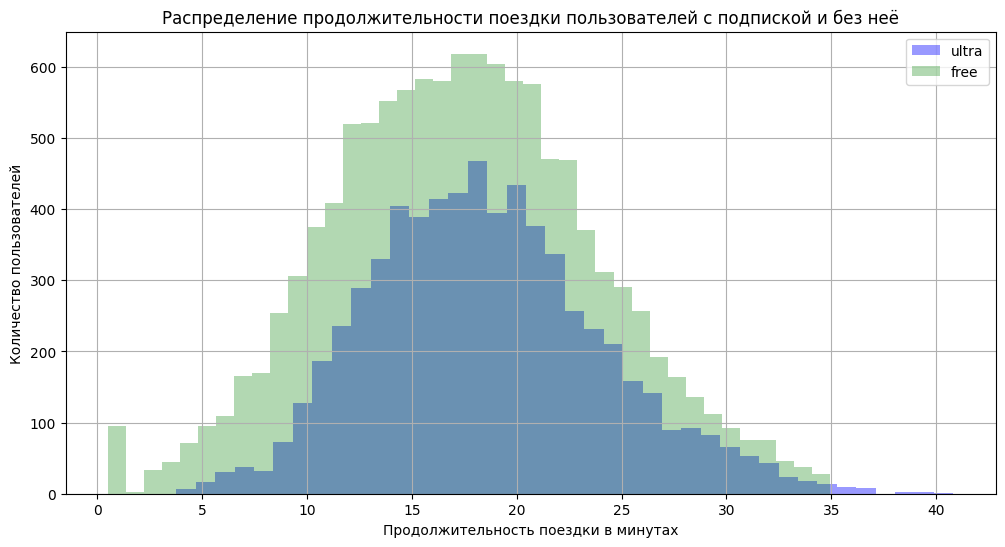

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(users_ultra['duration'], bins=40, alpha=0.4, label='ultra', color='blue')
ax.hist(users_free['duration'], bins=40, alpha=0.3, label='free', color='green')
plt.title('Распределение продолжительности поездки пользователей с подпиской и без неё')
plt.xlabel('Продолжительность поездки в минутах')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid()

In [63]:
users_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [64]:
users_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

**4.8** Продолжительность поездок пользователей с подпиской и без неё распределена похоже. Средняя (и самая популярная) продолжительность поездки у обоих категориий приблизительно одинакова (17-18 минут). И более 75% поездок для каждой группы длятся не более 22 минут. 

Можно отметить, что некоторые пользователи с подпиской пользовались самокатом более 35 минут, чего нельзя сказать о пользователях без подписки. 

В то же время у пользователей без подписки есть поездки продолжительностью менее 3 минут, чего нет у пользователей с подпиской. Возможно, новые пользователи без подписки не оценили данный вид передвижения. 

**Вывод:**
- Самое популярное расстояние, которые преодолевают пользователи с подпиской, составляет около 3 км. А то время как у пользователей без подписки пик значений лежит в большем диапазоне (от 2,4 до 3,4 км). Среднее и медианное значение у обоих типов пользователей почти одинаковы.
- Пользователи без подписки иногда преодолевают расстояния сверх 5,5 км, чего нельзя сказать о платных пользователях. 
- У пользователей без подписки разброс преодолеваемого расстояния шире. Возможно, такие клиенты совершают нерегулярные поездки, в то время как пользователи с подпиской часто ездят по одному маршруту (например, на работу).
- У пользователей без подписок больше поездок до 1 км. Возможно, наличие платной подписки свидетельствует о том, что клиенты ориентированы на более длинные расстояния.


- Средняя продолжительность поездки у обоих категориий приблизительно одинакова (17-18 минут). И более 75% поездок для каждой группы длятся не более 22 минут. 
- Некоторые пользователи с подпиской пользовались самокатом более 35 минут, чего нельзя сказать о пользователях без подписки.
- У пользователей без подписки есть поездки продолжительностью менее 3 минут, чего нет у пользователей с подпиской. Возможно, новые пользователи без подписки не оценили данный вид передвижения.

<a id="5"></a>
##  Подсчёт выручки

**5.1** Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из **шага 4**: найдём количество поездок, суммарное расстояние и суммарное время для каждого пользователя за каждый месяц.

Сюда же добавим данные о стоимости минуты поездки, стоимости старта и стоимости подписки для дальнейшего подсчёта помесячной выручки, которую принёс каждый пользователь. 

Чтобы узнать, можем ли мы при агрегации взять только первое значение этих столбцов, проверим, не менял ли какой-либо пользователь тип подписки. Для этого посчитаем количество уникальных подписок для каждого пользователя. Если кол-во таких значений не превышает 1, значит, пользователь имел только один тип подписки.

In [65]:
x = full_info.groupby('user_id')['subscription_type'].nunique()
x[x > 1].sum()

np.int64(0)

**5.2** После проверки мы уверены, что пользователи не меняли тип подписки. Значит, при агрегации данных можно взять только первое значение для каждого пользователя из столбцов `minute_price`, `start_ride_price`, `subscription_fee`, `subscription_type`.

Перед созданием сводной таблицы округлим продолжительность каждой поездки в каждой строке до следующего целого числа.

In [66]:
full_info['duration'] = np.ceil(full_info['duration'])


In [67]:
agg_info_rides = full_info.pivot_table(index=['user_id', 'month'], \
            values=['distance', 'duration', 'age', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'], \
            aggfunc={'distance':'sum', 'duration':'sum', 'age':'count', 'subscription_type':'first', 'minute_price':'first', 'start_ride_price':'first', 'subscription_fee':'first'})

agg_info_rides.rename(columns = {'age':'rides', 'distance':'all_distance', 'duration':'all_duration'}, inplace=True)

agg_info_rides.head(15)

rides  all_distance  all_duration  minute_price  \
user_id month                                                    
1       1          2   7027.511294          42.0             6   
        4          1    754.159807           7.0             6   
        8          2   6723.470560          46.0             6   
        10         2   5809.911100          32.0             6   
        11         3   7003.499363          56.0             6   
        12         2   6751.629942          28.0             6   
2       3          3  10187.723006          63.0             6   
        4          2   6164.381824          40.0             6   
        6          1   3255.338202          14.0             6   
        7          2   6780.722964          48.0             6   
        8          1    923.007439           7.0             6   
        10         1   2824.636598          19.0             6   
        12         1   3828.248580          12.0             6   
3       1          1   3061.777147          13.0             6   
        2          2   5421.152016          39.0             6   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra  
        12                    0               199             ultra  
2       3                     0               199             ultra  
        4                     0               199             ultra  
        6                     0               199             ultra  
        7                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        12                    0               199             ultra  
3       1                     0               199             ultra  
        2                     0               199             ultra

**5.3** В этот же датафрейм добавим столбец `month_revenue` с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к заранее добавленным столбцам, в которых содержится информация об условиях оплаты для подписчиков и тех, у кого нет подписки.

In [68]:
agg_info_rides['month_revenue'] = agg_info_rides['subscription_fee'] + \
                                  agg_info_rides['start_ride_price']*agg_info_rides['rides'] + \
                                  agg_info_rides['minute_price']*agg_info_rides['all_duration'] 
agg_info_rides.head(15)

rides  all_distance  all_duration  minute_price  \
user_id month                                                    
1       1          2   7027.511294          42.0             6   
        4          1    754.159807           7.0             6   
        8          2   6723.470560          46.0             6   
        10         2   5809.911100          32.0             6   
        11         3   7003.499363          56.0             6   
        12         2   6751.629942          28.0             6   
2       3          3  10187.723006          63.0             6   
        4          2   6164.381824          40.0             6   
        6          1   3255.338202          14.0             6   
        7          2   6780.722964          48.0             6   
        8          1    923.007439           7.0             6   
        10         1   2824.636598          19.0             6   
        12         1   3828.248580          12.0             6   
3       1          1   3061.777147          13.0             6   
        2          2   5421.152016          39.0             6   

               start_ride_price  subscription_fee subscription_type  \
user_id month                                                         
1       1                     0               199             ultra   
        4                     0               199             ultra   
        8                     0               199             ultra   
        10                    0               199             ultra   
        11                    0               199             ultra   
        12                    0               199             ultra   
2       3                     0               199             ultra   
        4                     0               199             ultra   
        6                     0               199             ultra   
        7                     0               199             ultra   
        8                     0               199             ultra   
        10                    0               199             ultra   
        12                    0               199             ultra   
3       1                     0               199             ultra   
        2                     0               199             ultra   

               month_revenue  
user_id month                 
1       1              451.0  
        4              241.0  
        8              475.0  
        10             391.0  
        11             535.0  
        12             367.0  
2       3              577.0  
        4              439.0  
        6              283.0  
        7              487.0  
        8              241.0  
        10             313.0  
        12             271.0  
3       1              277.0  
        2              433.0

**Вывод:**

В рамках **5-го шага** мы посчитали помесячную выручку, которую принёс каждый пользователь сервиса самокатов, с помощью сводной таблицы. 

<a id="6"></a>
##  Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

**6.1** Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

Итак, нам нужно узнать, тратят ли пользователи с подпиской больше времени на поездки. Сформулируем гипотезу:
- Нулевая гипотеза: средние значения времени поездки пользователей из двух групп равны.
- Альтернативная гипотеза: среднее значение времени поездки пользователей с подпиской больше, чем среднее значение времени поездки пользователей без подписки.

Проверим гипотезу. Возьмём уровень статистической значимости 0.05.

In [69]:
users_ultra_group = users_ultra['duration']
users_free_group = users_free['duration']

alpha = 0.05

results = st.ttest_ind(users_ultra_group, users_free_group, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


**6.2** Для ещё большей наглядности выведем средние значения продолжительности поездок для каждой категории пользователей.

In [70]:
print(users_ultra['duration'].mean())

18.54198516280583


In [71]:
print(users_free['duration'].mean())

17.39090929866399


p-value имеет очень маленькое значение. Средние значения продолжительности поездок для каждой категории пользователей не равны. А значит, мы отвергаем нулевую гипотезу о равенстве средних двух совокупностей. Значит, вполне вероятно, что **пользователи с подпиской тратят больше времени на поездки**, а значит, **пользователи с подпиской могут быть «выгоднее» для компании**.

**Проверим следующую гипотезу:**

**6.3** Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Сформулизаем гипотезу:

- Нулевая гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров. 
- Альтернативная гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за 1 поездку, больше 3130 метров. 

Проверим гипотезу. Возьмём уровень статистической значимости 0.05.


In [72]:
users_ultra_distance = users_ultra['distance']

optimal_value = 3130

alpha = 0.05

results = st.ttest_1samp(users_ultra_distance, optimal_value, alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


p-value близко к единице (0.92), значит, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, близко к 3130 метров, так как небольшое отклонение от заданного значения не даёт оснований отвергнуть нулевую гипотезу. 

На основании этих данных можно предположить, что **среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров**. Получается, такие пользователи — достаточно выгодные клиенты, так как показатель износа самокатов для такой дистанции оптимальный. 

**6.4** Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сформулируем гипотезу:

- Нулевая гипотеза: средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки.
- Альтернативная гипотеза: средняя помесячная выручка от пользователей с подпиской выше, чем средняя выручка от пользователей без подписки.

Для проверки гипотезы нужно датафрейм `agg_info_rides`, в котором хранятся данные о помесячной выручке, разделить на два датафрейма: с клиентами с подпиской и без неё. 

In [73]:
agg_info_rides_ultra = agg_info_rides.query('subscription_type == "ultra"')
agg_info_rides_ultra.head(10)

rides  all_distance  all_duration  minute_price  \
user_id month                                                    
1       1          2   7027.511294          42.0             6   
        4          1    754.159807           7.0             6   
        8          2   6723.470560          46.0             6   
        10         2   5809.911100          32.0             6   
        11         3   7003.499363          56.0             6   
        12         2   6751.629942          28.0             6   
2       3          3  10187.723006          63.0             6   
        4          2   6164.381824          40.0             6   
        6          1   3255.338202          14.0             6   
        7          2   6780.722964          48.0             6   

               start_ride_price  subscription_fee subscription_type  \
user_id month                                                         
1       1                     0               199             ultra   
        4                     0               199             ultra   
        8                     0               199             ultra   
        10                    0               199             ultra   
        11                    0               199             ultra   
        12                    0               199             ultra   
2       3                     0               199             ultra   
        4                     0               199             ultra   
        6                     0               199             ultra   
        7                     0               199             ultra   

               month_revenue  
user_id month                 
1       1              451.0  
        4              241.0  
        8              475.0  
        10             391.0  
        11             535.0  
        12             367.0  
2       3              577.0  
        4              439.0  
        6              283.0  
        7              487.0

In [74]:
agg_info_rides_free = agg_info_rides.query('subscription_type == "free"')
agg_info_rides_free.head(10)

rides  all_distance  all_duration  minute_price  \
user_id month                                                    
700     1          1   2515.690719          15.0             8   
        2          5  13446.659764          89.0             8   
        3          1   3798.334905          19.0             8   
        4          1   2984.551206          16.0             8   
        6          2   5927.650988          29.0             8   
        7          2   4399.206279          21.0             8   
        8          1   4071.654669          17.0             8   
        10         2   6322.578618          44.0             8   
        11         3   8735.782625          32.0             8   
701     1          1   2676.472894          18.0             8   

               start_ride_price  subscription_fee subscription_type  \
user_id month                                                         
700     1                    50                 0              free   
        2                    50                 0              free   
        3                    50                 0              free   
        4                    50                 0              free   
        6                    50                 0              free   
        7                    50                 0              free   
        8                    50                 0              free   
        10                   50                 0              free   
        11                   50                 0              free   
701     1                    50                 0              free   

               month_revenue  
user_id month                 
700     1              170.0  
        2              962.0  
        3              202.0  
        4              178.0  
        6              332.0  
        7              268.0  
        8              186.0  
        10             452.0  
        11             406.0  
701     1              194.0

**6.5** Теперь проверим выдвинутую гипотезу. Возьмём уровень статистической значимости 0.05.

In [75]:
month_revenue_ultra = agg_info_rides_ultra['month_revenue']
month_revenue_free = agg_info_rides_free['month_revenue']

alpha = 0.05 

results = st.ttest_ind(month_revenue_ultra, month_revenue_free, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**6.6** Дополнительно выведем среднее значение выручки для каждой категории пользователей.

In [77]:
print(agg_info_rides_ultra['month_revenue'].mean())

362.7921906022502


In [78]:
print(agg_info_rides_free['month_revenue'].mean())

328.6413651073845


p-value приняло очень низкое значение, и средние значения выручки каждой категории пользователей не равны. Значит, мы отвергаем нулевую гипотезу в пользу альтернативной. Получается, что предположение о том, что средняя помесячная выручка от пользователей с подпиской выше, чем средняя выручка от пользователей без подписки, является верным. Можно сделать вывод, что **пользователи с подпиской в среднем приносят больший ежемесячный доход, чем пользователи без подписки**. 

**Вывод:**

В рамках исследования были проверены 3 гипотезы и сделаны последующие выводы.

**Тратят ли пользователи с подпиской больше времени на поездки?**

Результат исследования показал высокую вероятность того, что пользователи с подпиской тратят больше времени на поездки, а значит, пользователи с подпиской могут быть более «выгодными» для компании.

**Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

Проверка гипотезы дала основание полагать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, близко к 3130 метров. Получается, такие пользователи — достаточно выгодные клиенты, так как целевое значение — это оптимальный показатель с точки зрения износа самокатов.

**Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки**.

В рамках проверки гипотезы был сделан вывод, что пользователи с подпиской потенциально приносят больший ежемесячный доход, чем пользователи без подписки.

Таким образом все три выдвинутые гипотезы не были опровергнуты, что является хорошим результатом. 


<a id="7"></a>
##  Общий вывод:

В рамках исследования мы:

1. **Обработали исходные данные на предмет пропусков и дубликатов**.


2. **Описали и визуализировали общую информацию о пользователях и поездках и сделали следующие выводы:**

- Количество пользователей в городах распределено достаточно равномерно: от 168 до 219 пользователей. Больше всего пользователей из Пятигорска (219), а меньше всего из Москвы (168).
- Среди пользователей самокатов достаточно большой процент имеет платную подписку.
- Пользователи самокатов являются молодой аудиторией.
- Самая популярная дистанция, которую проезжает пользователь за одну поездку, — примерно 3-3,3 км. Подавляющее большинство поездок распределены в интервале от 2 до 4,5 км.
- Самое популярное время поездки — 17 минут. Более 75% поездок длятся не более 22 минут.


3. **Отдельно рассмотрели данные о продолжительности и длительности поездок пользователей с подпиской и без неё.**

- Самое популярное расстояние, которые преодолевают пользователи с подпиской, составляет около 3 км. А то время как у пользователей без подписки пик значений лежит в большем диапазоне (от 2,4 до 3,4 км). Среднее и медианное значение у обоих типов пользователей почти одинаковы.
- Пользователи без подписки иногда преодолевают расстояния сверх 5,5 км, чего нельзя сказать о платных пользователях.
- У пользователей без подписки разброс преодолеваемого расстояния шире. Возможно, такие клиенты совершают нерегулярные поездки, в то время как пользователи с подпиской часто ездят по одному маршруту (например, на работу).
- У пользователей без подписок больше поездок до 1 км. Возможно, наличие платной подписки свидетельствует о том, что клиенты ориентированы на более длинные расстояния.


- Средняя продолжительность поездки у обоих категориий приблизительно одинакова (17-18 минут). И более 75% поездок для каждой группы длятся не более 22 минут.
- Некоторые пользователи с подпиской пользовались самокатом более 35 минут, чего нельзя сказать о пользователях без подписки.
- У пользователей без подписки есть поездки продолжительностью менее 3 минут, чего нет у пользователей с подпиской. Возможно, новые пользователи без подписки не оценили данный вид передвижения.

4. **Посчитали помесячную выручку, которую принёс каждый пользователь.**


5. **Проверили сформулированные гипотезы и сделали следующие выводы:**

- Результат исследования показал высокую вероятность того, что пользователи с подпиской тратят больше времени на поездки, а значит, пользователи с подпиской могут быть более «выгодными» для компании.

- Также подтвердилась гипотеза, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, близко к 3130 метров. Целевое значение — это оптимальный показатель с точки зрения износа самокатов.

- В рамках проверки гипотезы был сделан вывод, что пользователи с подпиской потенциально приносят больший ежемесячный доход, чем пользователи без подписки.

**Вывод:** Таким образом все три проверенные гипотезы дают основание полагать, что пользователи с подпиской являются более выгодными клиентами. Они тратят больше времени на поездки, приносят больший ежемесячный доход и проезжают оптимальное расстояние с точки зрения износа самокатов. 


**Рекомендации:**

- В предоставленных данных есть расстояния и продолжительность поездок, близкие к нулевому значению. В ходе исследования было выявлено, что значения, отражающие слишком низкую продолжительность поездки, являются недостоверными. Надо проверить алгоритм записи данных и актуализировать или удалить подобную информацию. Низкие данные по продолжительности поездки тоже следует проверить и, возможно, удалить как выбросы, для дальшейших исследований.
- Рекомендовано провести запланированные компанией акции по стимулированию пользователей с целью подписки, так как это может принести хороший доход компании в долгосрочной перспективе. 
- Для прогнозирования прибыли в будущем рекомендуем использовать рассчёт ежемесячного дохода, которые принёс каждый пользователь, так как этот показатель хорошо отражает приклекательность клиентов для компании. Данный рассчёт был произведён в этом исследовании. 

